In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, ifftshift, fftshift

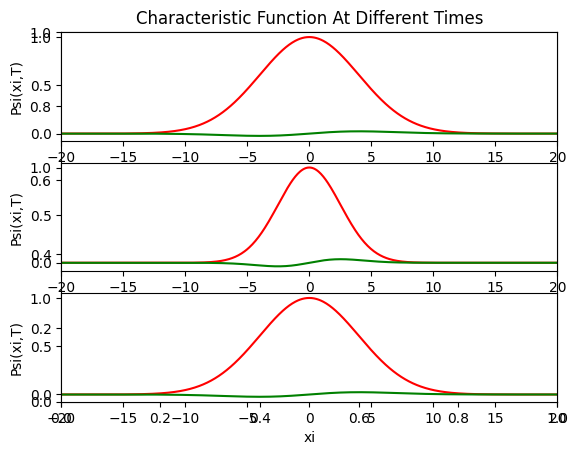

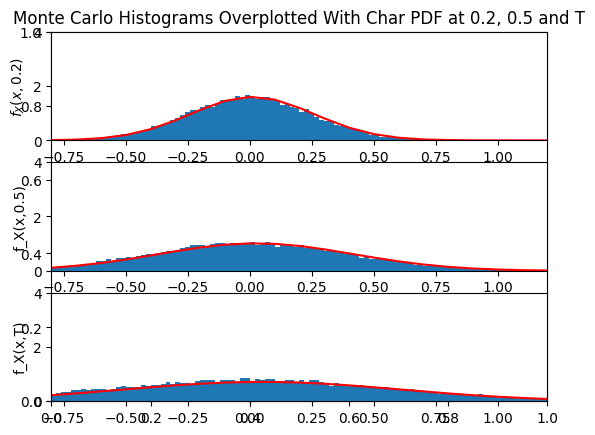

In [2]:
#  ---- Model Parameters ----

# Model parameter
eta1 = 10 # Rate of first distribution
eta2 = 10 # Rate of second distribution
prob = 0.5 # Probability of being positive
lmbda = 0.5
sigma = 0.55

muS = 0.2
# parameters of the jump:
muJ=-0.1
#increasing sigmaJ can increase the size of the jumps ie 0.45
sigmaJ=0.15
#increasing lamda can increase the number of jumps i.e 1.5:
lmbda=0.5

# Define parameters and time grid
npaths = 20000  # number of paths
T = 1  # time horizon
nsteps = 200  # number of time steps
dt = T/nsteps  # time step
t = np.arange(0, T + dt, dt)  # observation times

U = np.random.uniform(size=(nsteps, npaths))
randLaplace = np.where(U < prob, np.random.laplace(scale=1/eta1, size=(nsteps, npaths)), np.random.laplace(scale=1/eta2, size=(nsteps, npaths)))

## Monte Carlo
# Compute the increments of the arithmetic Brownian motion X = log(S/S0)==>S = S0 * np.exp(X)
dW = (muS-0.5*sigma**2)*dt + sigma*np.random.randn(nsteps, npaths)* np.sqrt(dt)

#Compute the increments of the NCPP:
dN = np.random.poisson(lmbda*dt, size=(nsteps, npaths))
dJ = muJ * dN + sigmaJ*randLaplace* np.sqrt(dN)
dX= dW+dJ

# Accumulate the increments
X = np.concatenate([np.zeros((1, npaths)), np.cumsum(dX, axis=0)], axis=0)

# -- FOURIER TRANSFORMATION SECTION -----
# -- Transformation Parameters --

# GRID IN REAL SPACE
N = 1000 # Number of grid points
dx = 0.1 # Grid step size in real space
upperx = N*dx # Upper truncation limit in real space
x = dx * np.arange(-N/2, N/2)  # grid in real space

# GRID IN FOURIER SPACE (Pulsation)
dxi = (2*np.pi)/(N*dx) #Grid step size in fourier space
upperxi = N*dxi # Upper truncation limit in fourier space
xi = dxi * np.arange(-N/2, N/2)  # grid in Fourier space

# GRID IN FOURIER SPACE (Frequency)
dnu = 1/(N*dx) # Grid step size in fourier space
uppernu = N*dnu # Upper truncation limit in fourier space
nu = dnu* np.arange(-N/2, N/2)  #Grid in fourier space


# Characteristic function - using parameters of the monte-carlo SDE equation.
def Fa(t):
    """
    Characteristic function for the Kou jump-diffusion process.

    Parameters:
    u (complex): The argument of the characteristic function.
    t (float): Time at which the characteristic function is evaluated.
    mu (float): Drift coefficient of the process.
    sigma (float): Volatility coefficient of the process.
    lambda_ (float): Jump intensity.
    p (float): Probability of positive jumps.
    eta1 (float): Parameter for the exponential distribution of positive jumps.
    q (float): Probability of negative jumps.
    eta2 (float): Parameter for the exponential distribution of negative jumps.

    Returns:
    complex: Value of the characteristic function for the Kou jump-diffusion process.
    """
    gamma = muS - (sigma**2) / 2
    jump_component = prob * eta1 / (eta1 - 1j*xi) + (1-prob) * eta2 / (eta2 + 1j*xi) - 1
    return np.exp(1j * xi * gamma * t - (sigma**2) * xi**2 * t / 2 + lmbda * t * jump_component)



fa = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(Fa(T)))) / upperx  # PDE at last timestep

# Repeat the process for frequency space
expon1 = lmbda * ((prob * eta1) / (eta1 - 1j * (2 * np.pi * nu)) + ((1 - prob) * eta2) / (eta2 + 1j * (2 * np.pi * nu)) - 1)
char_func1 = np.exp((1j * (2 * np.pi * nu) * muS - 0.5 * ((2 * np.pi * nu) * sigma)**2) * T + expon1 * T)
fa1 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(char_func1))) / (N * dx)


# -- Visualisation of Real And Imaginary Characteristic function at 0.1, 0.5 and T -----
# -- Plot Characteristic Function at time T --
# Inverse Fourier Transformation to get the function at different points
Fa_point2 = Fa(0.2) # Characteristic Function at 0.2
Fa_point5 = Fa(0.5) # Characteristic Function at 0.5
Fa_T = Fa(T) # Characteristic Function at T

# Plot at 0.2 - Characteristic Function
plt.figure(1)
plt.title('Characteristic Function At Different Times')

plt.subplot(3, 1, 1)
plt.plot(xi, np.real(Fa_point2), 'r', xi, np.imag(Fa_point2), 'g')
plt.xlabel('xi')
plt.xlim([-20, 20])
plt.ylabel('Psi(xi,T)')

# Plot at 0.5 - Characteristic Function
plt.subplot(3, 1, 2)
plt.plot(xi, np.real(Fa_point5), 'r', xi, np.imag(Fa_point5), 'g')
plt.xlabel('xi')
plt.xlim([-20, 20])
plt.ylabel('Psi(xi,T)')

# Plot at T - Characteristic Function
plt.subplot(3, 1, 3)
plt.plot(xi, np.real(Fa_point2), 'r', xi, np.imag(Fa_point2), 'g')
plt.xlabel('xi')
plt.xlim([-20, 20])
plt.ylabel('Psi(xi,T)')

# -- Visualisation of PDFs at Different Points VS Monte Carlo -----
# Inverse Fourier Transformation to get the function at different points
fn_point2 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(Fa(0.2)))) / upperx  # Function at 0.2
fn_point5 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(Fa(0.5)))) / upperx  # Function at 0.5
fn_1 = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(Fa(1)))) / upperx  # Function at 1

# Plot at 0.2 - real PDF
plt.figure(2)
plt.title('Monte Carlo Histograms Overplotted With Char PDF at 0.2, 0.5 and T')

plt.subplot(3, 1, 1)
plt.hist(X[40, :], bins=np.arange(-0.8, 1.21, 0.02), density=True)
plt.plot(x, np.real(fn_point2), 'r')
plt.xlim([-0.8, 1.2])
plt.ylim([0, 4])
plt.ylabel(f'$f_X(x,0.2)$')

# Plot at 0.5 - real PDF
plt.subplot(3, 1, 2)
plt.hist(X[100, :], bins=np.arange(-0.8, 1.21, 0.02), density=True)
plt.plot(x, np.real(fn_point5), 'r')
plt.xlim([-0.8, 1.2])
plt.ylim([0, 4])
plt.ylabel('f_X(x,0.5)')

# Plot at 1 - real PDF
plt.subplot(3, 1, 3)
plt.hist(X[-1, :], bins=np.arange(-0.8, 1.21, 0.02), density=True)
plt.plot(x, np.real(fn_1), 'r')
plt.xlim([-0.8, 1.2])
plt.ylim([0, 4])
plt.ylabel('f_X(x,T)')

# Showing different plots
plt.show()